In [ ]:
import sys
sys.path.append("..")

In [1]:
# ============================================================
# M-GW: Pairwise Alignment of Spatiotemporal Mouse Embryo Slices
# ============================================================

import scanpy as sc
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import util, models, plotting, geometry
from mgw import pullback_metric_field, knn_graph
from mgw.gw import solve_gw_ott
import importlib
import matplotlib.pyplot as plt
import os

# ----------------------------
# Runtime & device setup
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Input files & parameters
# ----------------------------
filehandles_embryo_adata = [
    '/scratch/gpfs/ph3641/mouse_embryo/E9.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E10.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E11.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E12.5_E1S1.MOSTA.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/E13.5_E1S1.MOSTA.h5ad'
]
timepoints = ['E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

# Embedding / network parameters
PCA_comp   = 30
knn_k      = 12
geodesic_eps = 0.01

gw_params = dict(verbose=True, inner_maxit=3000, outer_maxit=3000,
                 inner_tol=1e-7, outer_tol=1e-7, epsilon=1e-4)

save_dir = "/scratch/gpfs/ph3641/mgw/ME_Alignments"
os.makedirs(save_dir, exist_ok=True)

# ============================================================
# 1. Load datasets and prepare
# ============================================================
print('Loading AnnData slices...')
adatas = []
for i, fh in enumerate(filehandles_embryo_adata):
    adata = sc.read_h5ad(fh)
    adata.X = adata.layers['count']
    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]
    adatas.append(adata)

# Intersect genes across all slices
common_genes = list(set.intersection(*[set(a.var_names) for a in adatas]))
adatas = [a[:, common_genes] for a in adatas]
print(f"Common genes: {len(common_genes)}")


Device: cuda
Loading AnnData slices...
Common genes: 23787


In [2]:
from mgw import metrics
from scipy.spatial.distance import cdist


--- Aligning E9.5 → E10.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
PCA shapes -> X: (5913, 30) Z: (18408, 30)
Feeler GW sizes: X-side 5913, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈3.6704e-03
Computing CCA Components
CCA dims: 3  (applied to full sets)
dims: 2 3 3


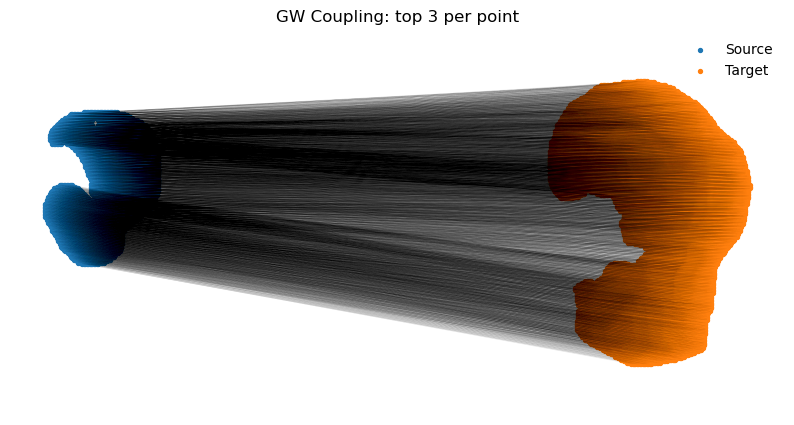

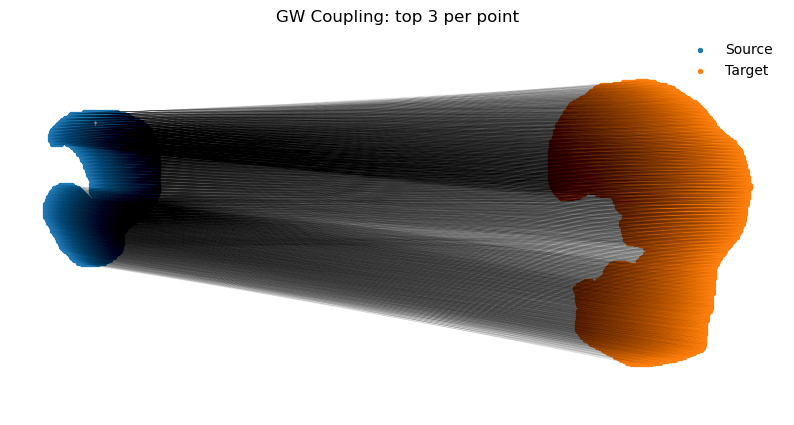

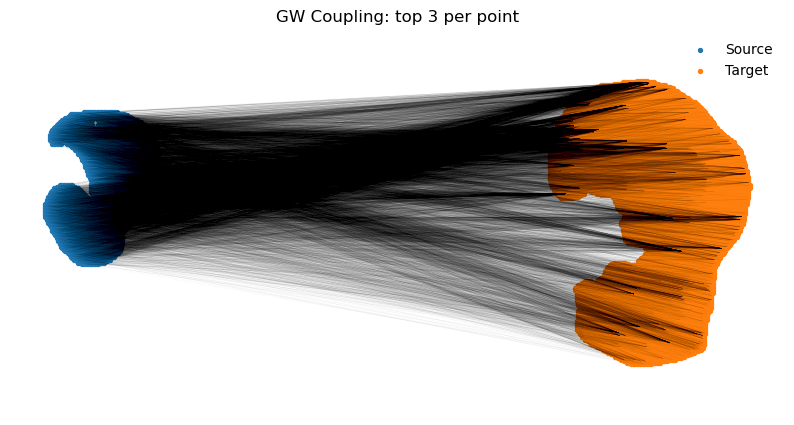


--- Aligning E10.5 → E11.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
PCA shapes -> X: (10000, 30) Z: (10000, 30)
Feeler GW sizes: X-side 8000, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈4.0359e-03
Computing CCA Components
CCA dims: 10  (applied to full sets)
dims: 2 10 10
[train_phi] step=1000 loss=0.524142
[train_phi] step=2000 loss=0.440411
[train_phi] step=3000 loss=0.409313
[train_phi] step=4000 loss=0.398595
[train_phi] step=5000 loss=0.497088
[train_phi] step=6000 loss=0.384387
[train_phi] step=7000 loss=0.376576
[train_phi] step=8000 loss=0.374054
[train_phi] step=9000 loss=0.367932
[train_phi] step=10000 loss=0.360218
[train_phi] step=11000 loss=0.371224
[train_phi] step=12000 loss=0.358588
[train_phi] step=13000 loss=0.360397
[train_phi] step=14000 loss=0.347766
[train_phi] step=15000 loss=0.348317
[train_phi] step=16000 loss=0.346492
[train_phi] step=17000 loss=0.340198
[train_phi] step=18000 loss=0.338582
[train_phi] step=19000 loss=0.3

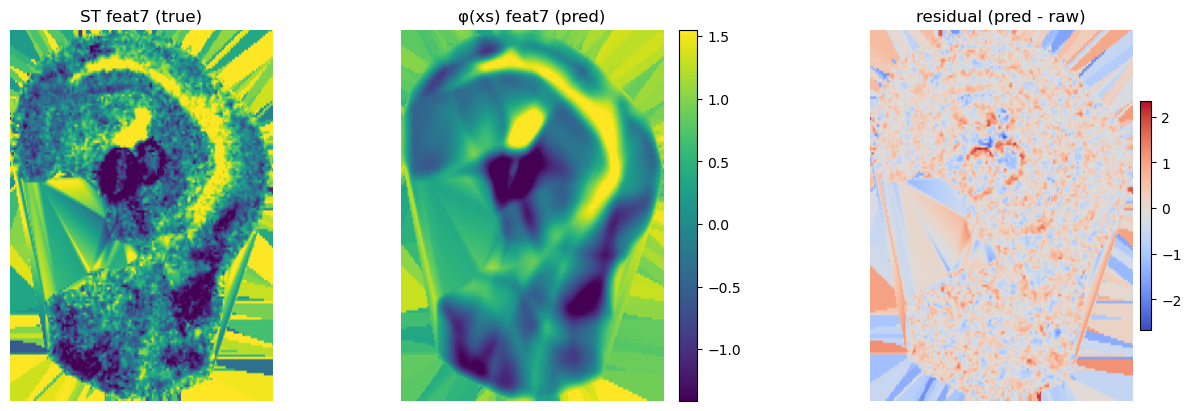

φ feat 7 {'mse': np.float64(0.34143944214064315), 'r2': np.float64(0.6585264033885881), 'corr': np.float64(0.8116823189264676)}


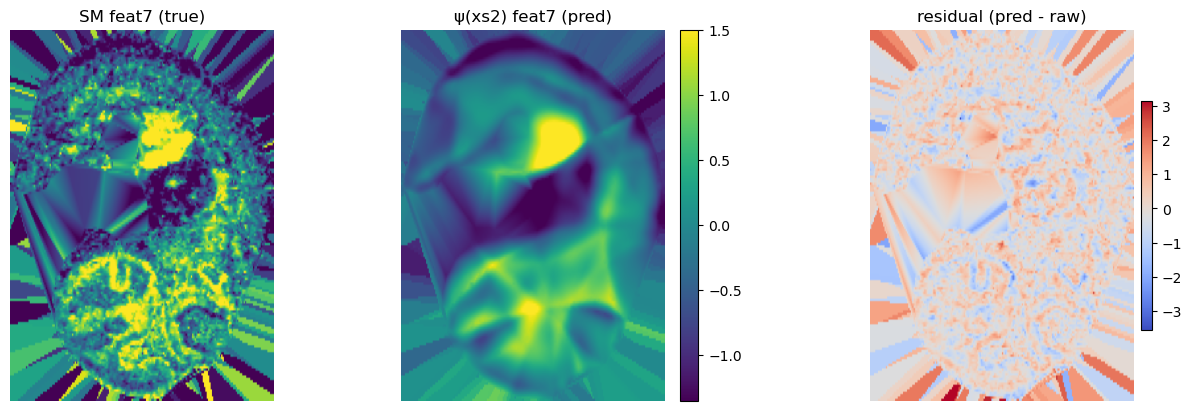

ψ feat 7 {'mse': np.float64(0.48538632503215784), 'r2': np.float64(0.5145651259857913), 'corr': np.float64(0.7185057637269939)}


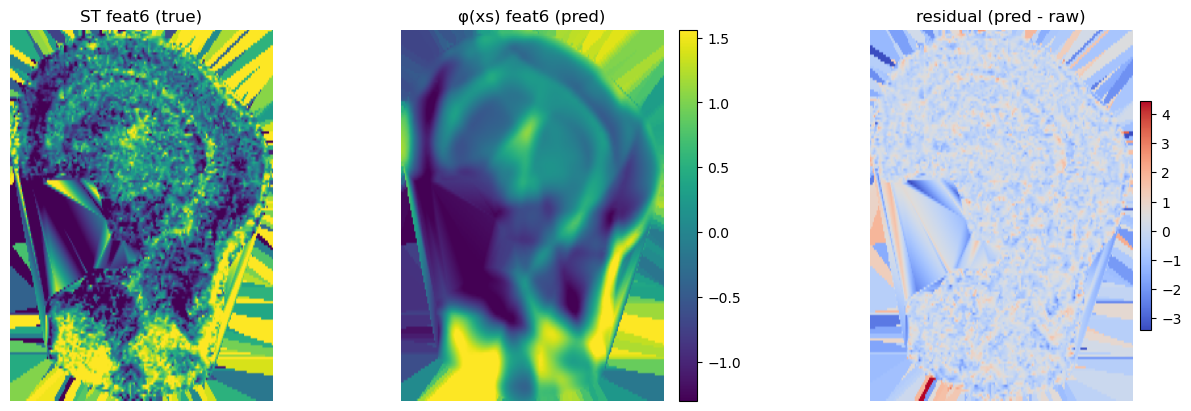

φ feat 6 {'mse': np.float64(0.49168999526299956), 'r2': np.float64(0.5082608203780534), 'corr': np.float64(0.7129580229051181)}


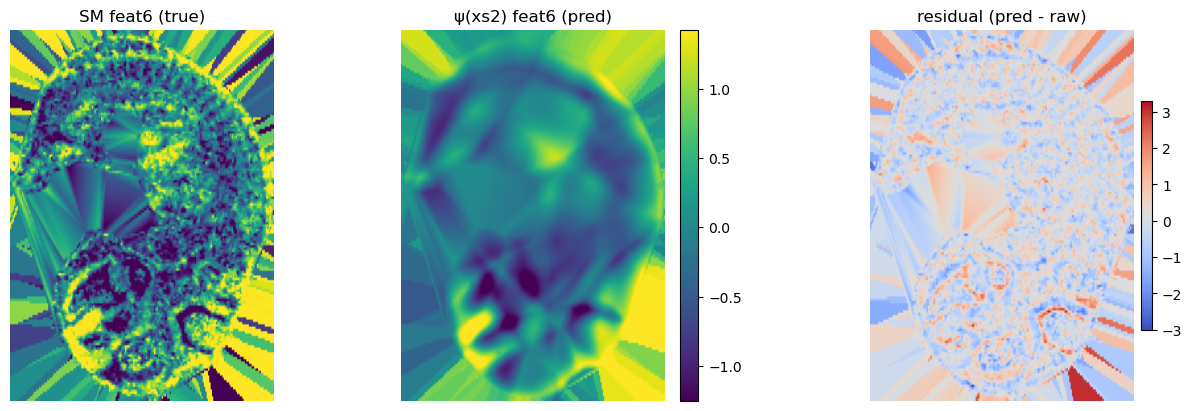

ψ feat 6 {'mse': np.float64(0.6230237133239582), 'r2': np.float64(0.3769139709032556), 'corr': np.float64(0.6149281373660416)}
Computing metric fields
Rescaling Jacobians by 1528.2935491374228.
Rescaling Jacobians by 1338.213478382338.
Computing geodesic distances
Solving GW...
[OTT] GW  ε=1.00e-04  iters=-1  loss≈1.0593e-03
Coupling shape: (10000, 10000), mass=1.000
Visualizing alignment...


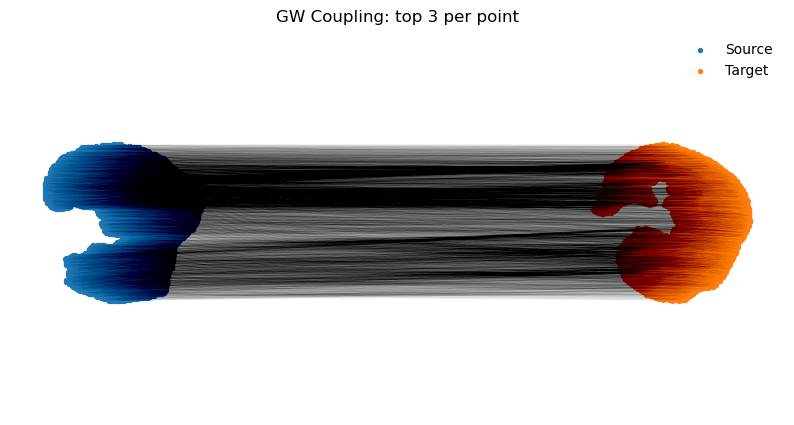

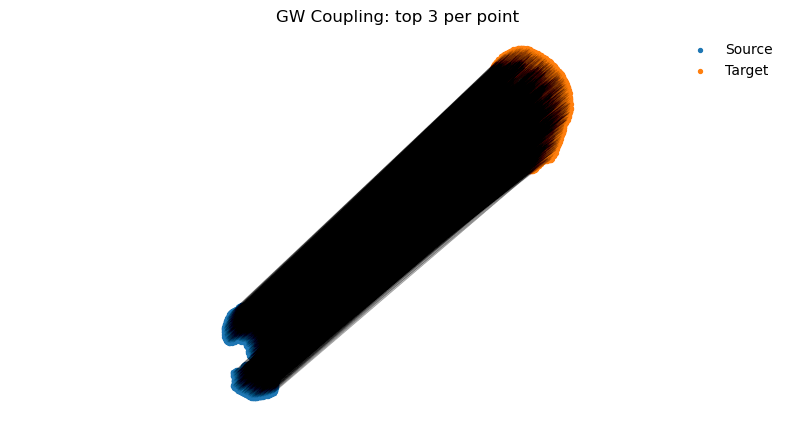

[OTT] GW  ε=1.00e-04  iters=-1  loss≈1.6727e-03


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


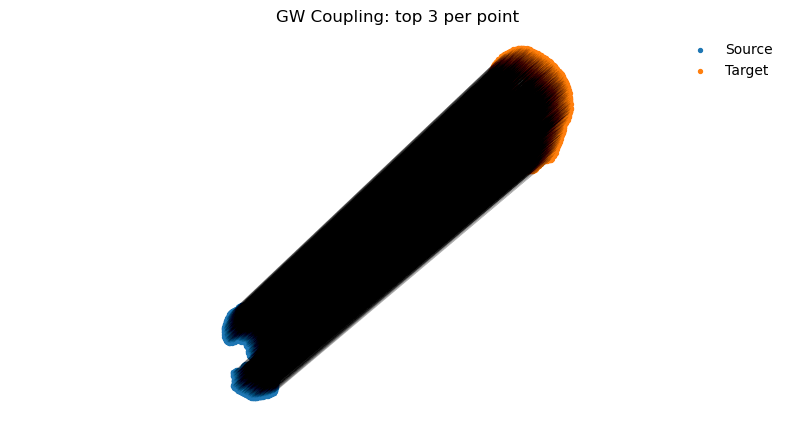

[OTT] GW  ε=1.00e-04  iters=-1  loss≈5.2874e-03


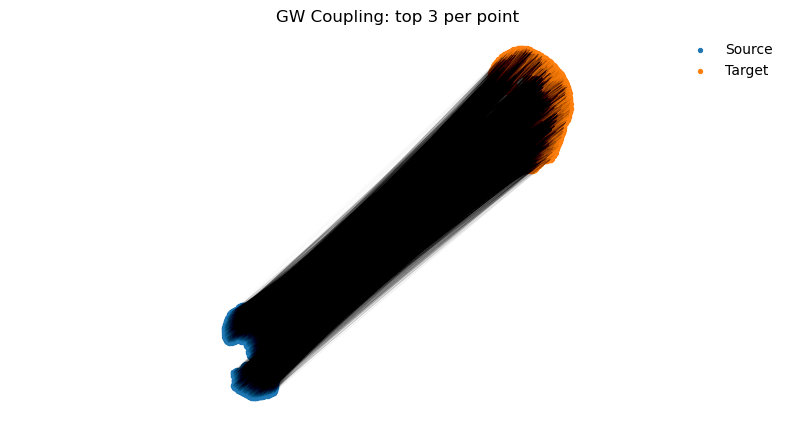


--- Aligning E11.5 → E12.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
PCA shapes -> X: (10000, 30) Z: (10000, 30)
Feeler GW sizes: X-side 8000, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈4.2997e-03
Computing CCA Components
CCA dims: 10  (applied to full sets)
dims: 2 10 10
[train_phi] step=1000 loss=0.414939
[train_phi] step=2000 loss=0.365146
[train_phi] step=3000 loss=0.348627
[train_phi] step=4000 loss=0.339643
[train_phi] step=5000 loss=0.331165
[train_phi] step=6000 loss=0.316292
[train_phi] step=7000 loss=0.308433
[train_phi] step=8000 loss=0.316226
[train_phi] step=9000 loss=0.296575
[train_phi] step=10000 loss=0.305635
[train_phi] step=11000 loss=0.307122
[train_phi] step=12000 loss=0.284718
[train_phi] step=13000 loss=0.295458
[train_phi] step=14000 loss=0.277433
[train_phi] step=15000 loss=0.287005
[train_phi] step=16000 loss=0.279388
[train_phi] step=17000 loss=0.273849
[train_phi] step=18000 loss=0.271897
[train_phi] step=19000 loss=0.2

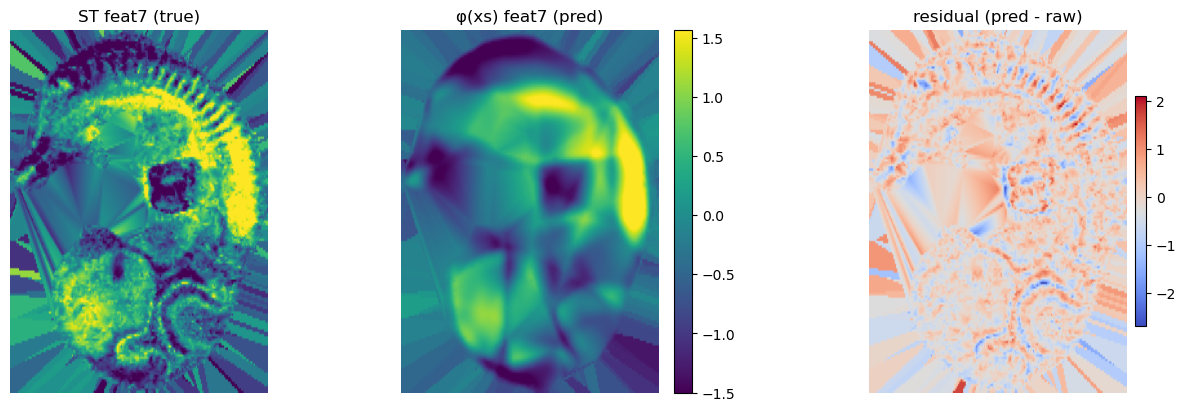

φ feat 7 {'mse': np.float64(0.34148858281788863), 'r2': np.float64(0.6584772583998011), 'corr': np.float64(0.8155103365104623)}


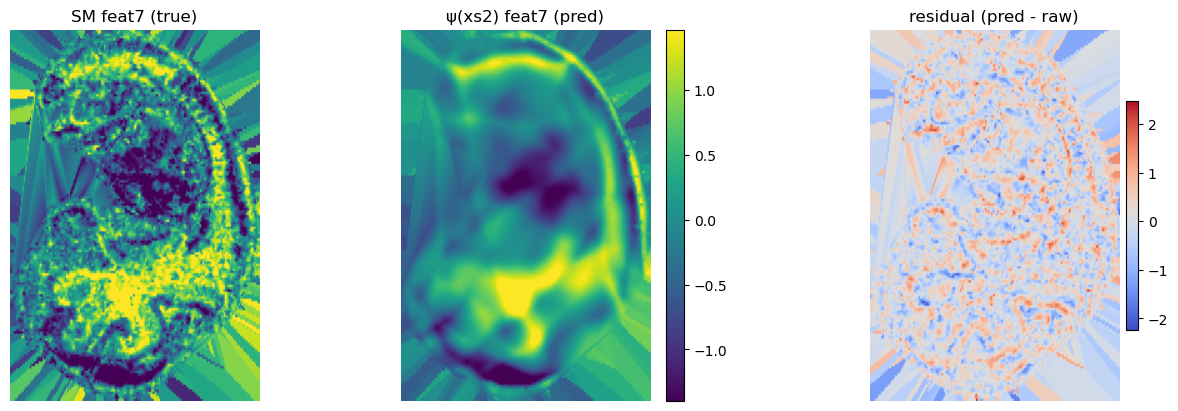

ψ feat 7 {'mse': np.float64(0.49859885275239996), 'r2': np.float64(0.5013512766482046), 'corr': np.float64(0.7106254154227726)}


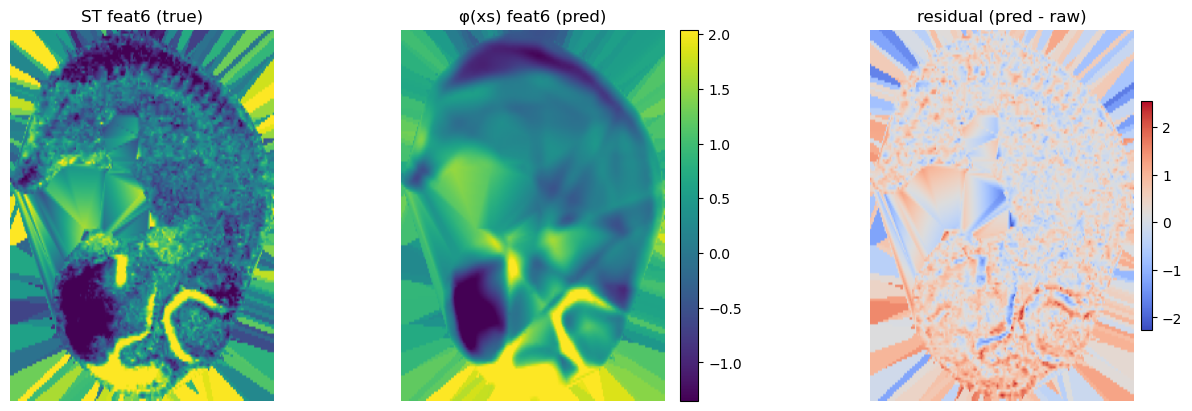

φ feat 6 {'mse': np.float64(0.40454127548115176), 'r2': np.float64(0.5954182555152101), 'corr': np.float64(0.8298227896162202)}


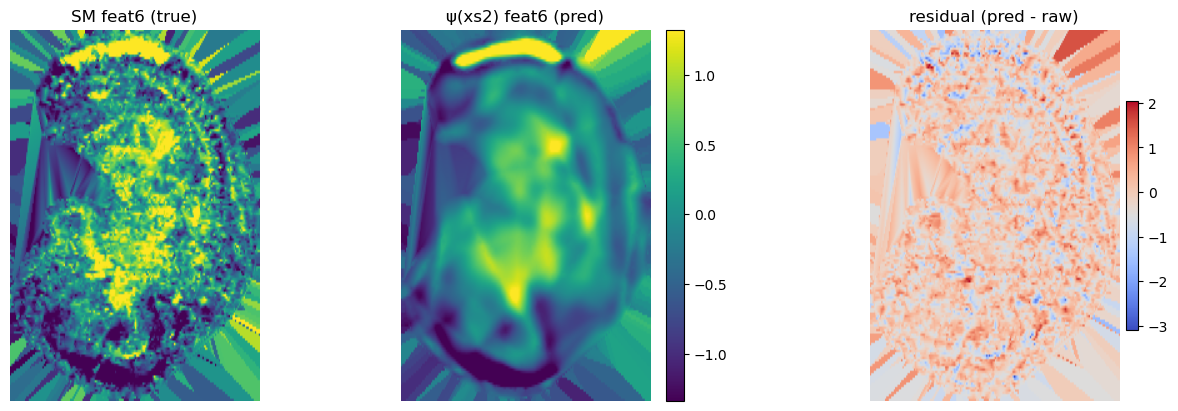

ψ feat 6 {'mse': np.float64(0.4668723256689877), 'r2': np.float64(0.5330809767167763), 'corr': np.float64(0.7350646418984049)}
Computing metric fields
Rescaling Jacobians by 1595.0462253584676.
Rescaling Jacobians by 1377.5476346387945.
Computing geodesic distances
Solving GW...
[OTT] GW  ε=1.00e-04  iters=-1  loss≈2.4797e-03
Coupling shape: (10000, 10000), mass=1.000
Visualizing alignment...


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


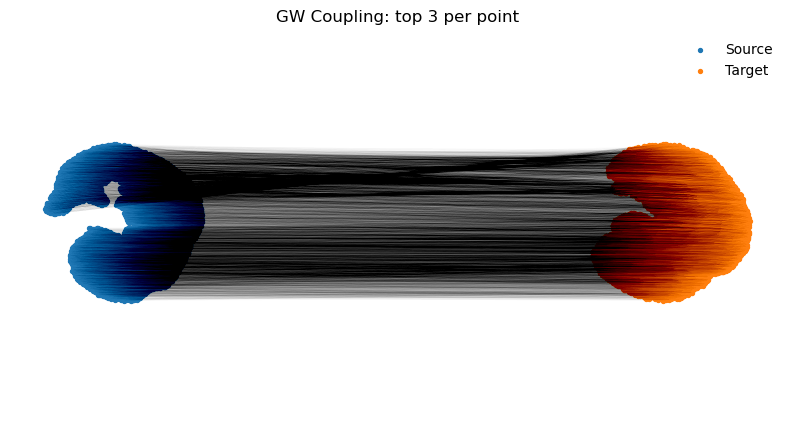

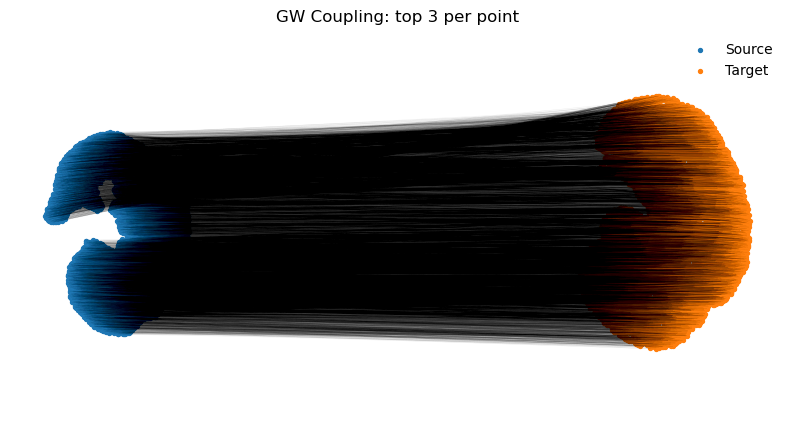

[OTT] GW  ε=1.00e-04  iters=-1  loss≈1.5288e-03


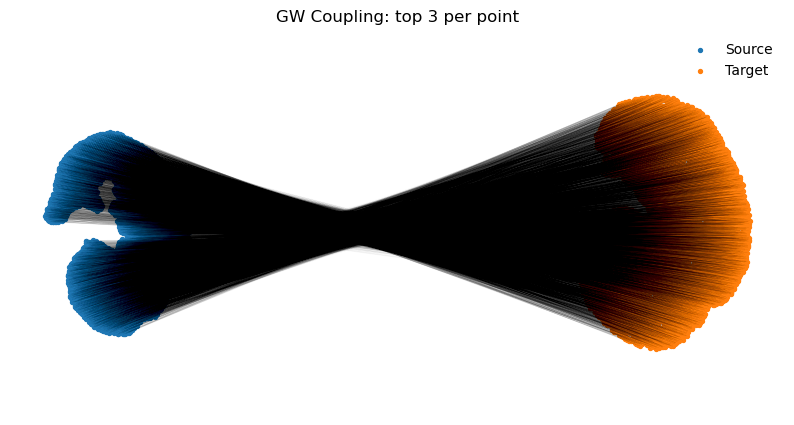

[OTT] GW  ε=1.00e-04  iters=-1  loss≈3.6701e-03


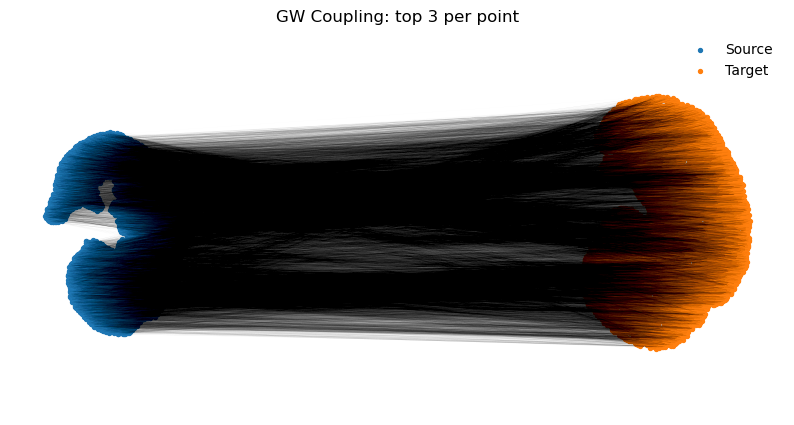


--- Aligning E12.5 → E13.5 ---


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Using precomputed PCA (30 comps).
Using precomputed PCA (30 comps).
PCA shapes -> X: (10000, 30) Z: (10000, 30)
Feeler GW sizes: X-side 8000, Z-side 8000
Solving feeler feature alignment.
[OTT] GW  ε=1.00e-03  iters=-1  loss≈2.6265e-03
Computing CCA Components
CCA dims: 10  (applied to full sets)
dims: 2 10 10
[train_phi] step=1000 loss=0.407187
[train_phi] step=2000 loss=0.336043
[train_phi] step=3000 loss=0.328421
[train_phi] step=4000 loss=0.298785
[train_phi] step=5000 loss=0.287651
[train_phi] step=6000 loss=0.327302
[train_phi] step=7000 loss=0.276121
[train_phi] step=8000 loss=0.287242
[train_phi] step=9000 loss=0.270867
[train_phi] step=10000 loss=0.289213
[train_phi] step=11000 loss=0.262471
[train_phi] step=12000 loss=0.261065
[train_phi] step=13000 loss=0.258931
[train_phi] step=14000 loss=0.249259
[train_phi] step=15000 loss=0.246644
[train_phi] step=16000 loss=0.246718
[train_phi] step=17000 loss=0.243208
[train_phi] step=18000 loss=0.241134
[train_phi] step=19000 loss=0.2

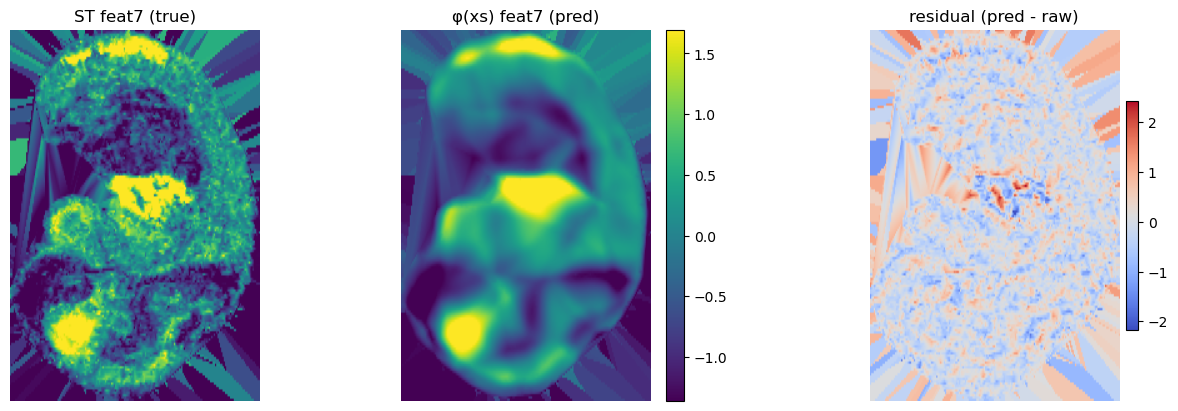

φ feat 7 {'mse': np.float64(0.3193280076587602), 'r2': np.float64(0.6806400501476522), 'corr': np.float64(0.8258285833513244)}


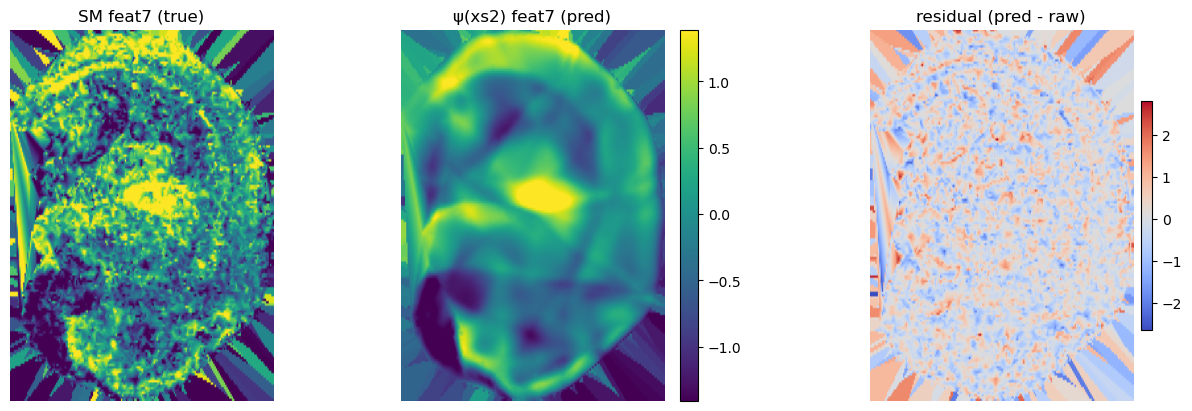

ψ feat 7 {'mse': np.float64(0.5823425454706094), 'r2': np.float64(0.41759920757158964), 'corr': np.float64(0.6467587242694449)}


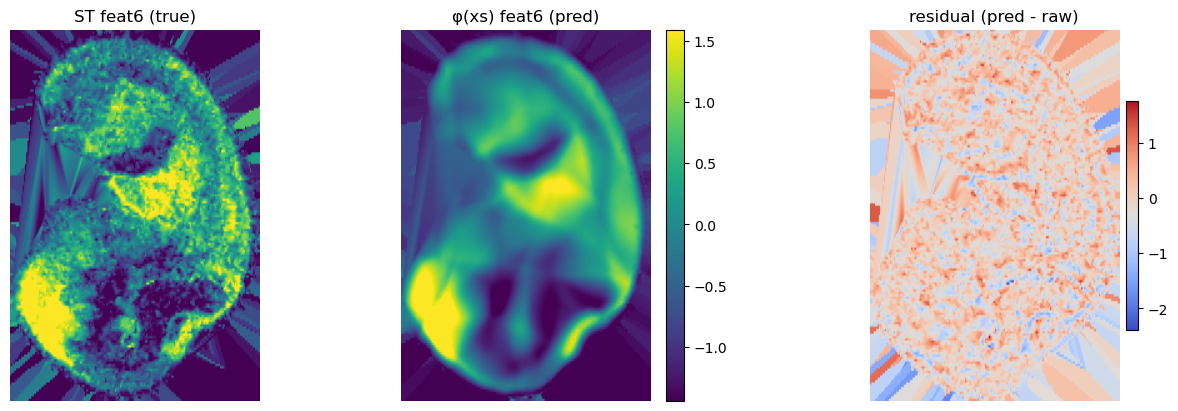

φ feat 6 {'mse': np.float64(0.28712922450504785), 'r2': np.float64(0.7128420536350173), 'corr': np.float64(0.8449067558811674)}


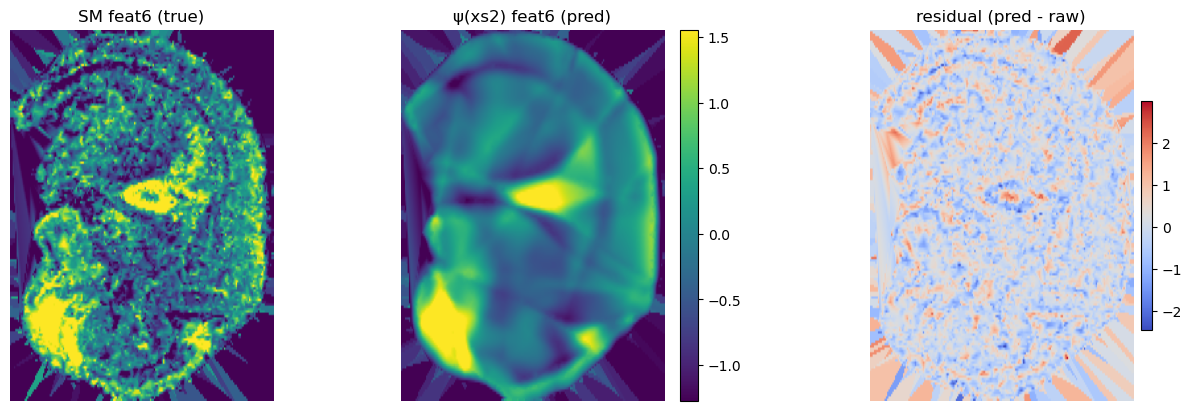

ψ feat 6 {'mse': np.float64(0.5618861425808556), 'r2': np.float64(0.43805765670184815), 'corr': np.float64(0.6619534554084975)}
Computing metric fields
Rescaling Jacobians by 1428.1707130277757.
Rescaling Jacobians by 1039.6206375965687.
Computing geodesic distances
Solving GW...
[OTT] GW  ε=1.00e-04  iters=-1  loss≈2.2664e-03
Coupling shape: (10000, 10000), mass=1.000
Visualizing alignment...


/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


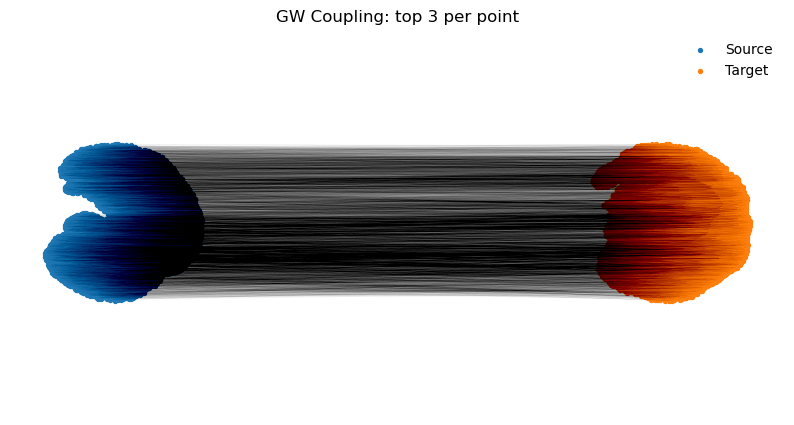

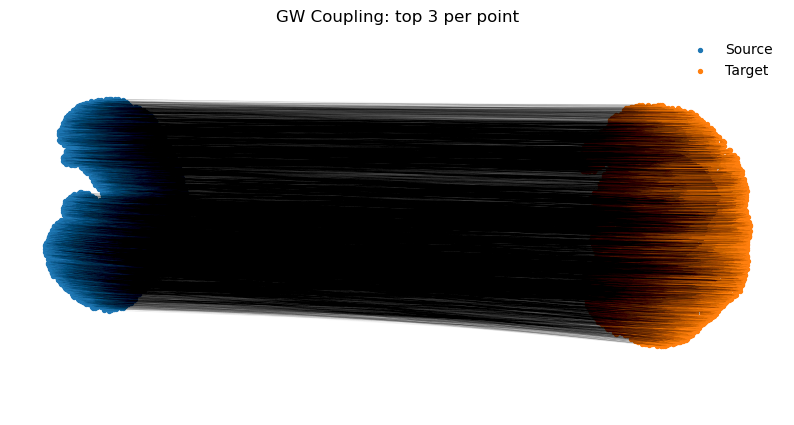

[OTT] GW  ε=1.00e-04  iters=-1  loss≈9.1453e-04


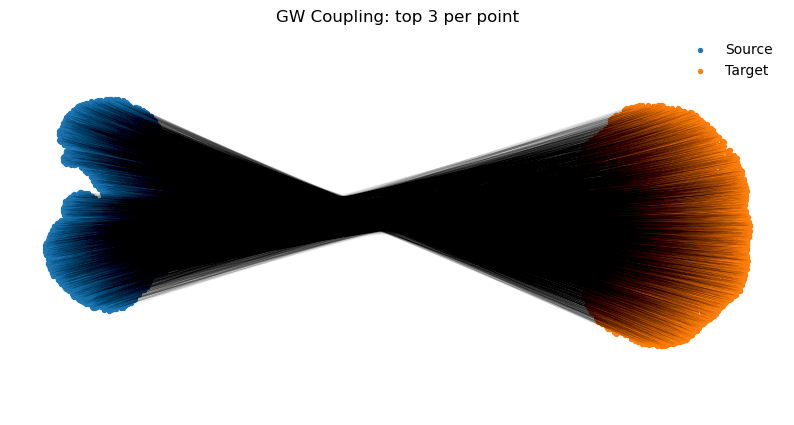

[OTT] GW  ε=1.00e-04  iters=-1  loss≈3.8290e-03


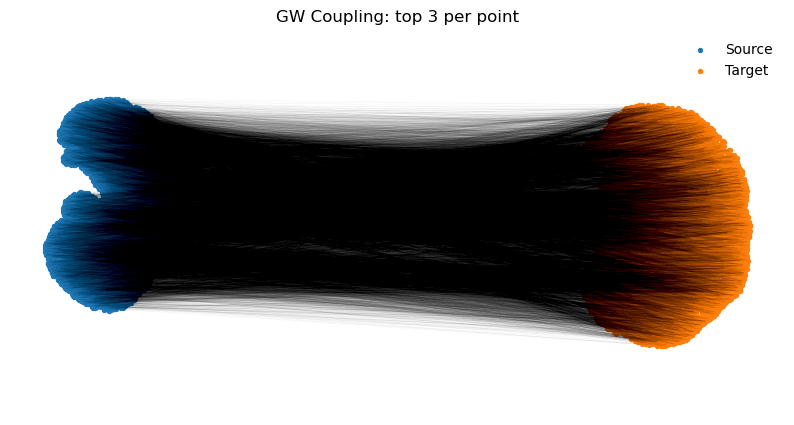

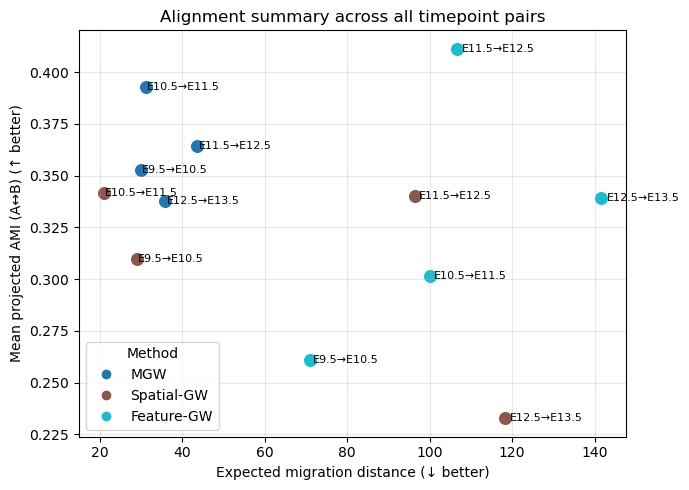

In [3]:

# ============================================================
# 2. Loop over consecutive pairs (E11.5→E12.5, E12.5→E13.5)
# ============================================================
importlib.reload(geometry)

CCA_comps = [3, 10, 10, 10]
N_downsample = 10_000

for i in range(len(adatas)-1):
    
    ad1, ad2 = adatas[i], adatas[i+1]
    
    if i > 0:
        # Need to downsample beyond first pair (for now)
        ad1 = util.downsample_per_slice(ad1, max_obs=N_downsample, random_state=42)
        ad2 = util.downsample_per_slice(ad2, max_obs=N_downsample, random_state=42)
    
    tp1, tp2 = timepoints[i], timepoints[i+1]
    print(f"\n--- Aligning {tp1} → {tp2} ---")
    
    # Normalization, log1p, PCA
    joint = ad.concat([ad1, ad2], join='inner')
    
    sc.pp.normalize_total(joint)
    sc.pp.log1p(joint)
    sc.pp.pca(joint, n_comps=PCA_comp)
    
    # Split back into slices
    A = joint[joint.obs['timepoint'] == tp1].copy()
    B = joint[joint.obs['timepoint'] == tp2].copy()
    
    # Ensure spatial coords exist
    xs = np.asarray(A.obsm["spatial"], dtype=float)
    xs2 = np.asarray(B.obsm["spatial"], dtype=float)
    xs_n = util.normalize_coords_to_unit_square(xs)
    xs2_n = util.normalize_coords_to_unit_square(xs2)
    
    # ========================================================
    # (a) Feature preprocessing (PCA + CCA "feeler")
    # ========================================================
    CCA_comp = CCA_comps[i]
    results = util.project_informative_features(path_X=None, path_Z=None,
        adata_X=A, adata_Z=B, PCA_comp=PCA_comp, CCA_comp=CCA_comp,
        n_downsample=8000
    )
    
    ys, ys2 = results["X_cca_full"], results["Z_cca_full"]
    Y, Y2 = results["X_pca"], results["Z_pca"]
    
    # ========================================================
    # (b) Train neural fields φ, ψ : (coords)->(features)
    # ========================================================
    xs_t, xs2_t = torch.from_numpy(xs_n).to(device), torch.from_numpy(xs2_n).to(device)
    
    #ys_t = torch.from_numpy(Y).to(device=device, dtype=xs_t.dtype)
    ys_t = util.normalize_range(torch.from_numpy(ys).to(device)) #<--- CCA not technically needed since unimodal!
    #ys2_t = torch.from_numpy(Y2).to(device=device, dtype=xs_t.dtype)
    ys2_t = util.normalize_range(torch.from_numpy(ys2).to(device))
    
    dim_e, dim_f_M, dim_f_N = 2, ys_t.shape[1], ys2_t.shape[1]
    print("dims:", dim_e, dim_f_M, dim_f_N)
    
    if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy")):
        
        phi = models.PhiModel(dim_e, dim_f_M, widths=(128,256,256,128)).to(device)
        psi = models.PhiModel(dim_e, dim_f_N, widths=(128,256,256,128)).to(device)
        
        phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=20_000, print_every=1000, device=device)
        psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=20_000, print_every=1000, device=device)
        phi.eval(); psi.eval()
        
        from mgw.plotting import fit_metrics
        rng = np.random.default_rng(0)
        for k in rng.choice(dim_f_M, size=min(2, dim_f_M), replace=False):
            X_pred = plotting.predict_on_model(phi, xs_n)
            plotting.plot_fit_on_cloud(xs, ys_t[:,k].cpu().numpy(), X_pred[:,k],
                                       title_true=f'ST feat{k} (true)', title_pred=f'φ(xs) feat{k} (pred)')
            print('φ feat', k, fit_metrics(ys_t[:,k].cpu().numpy(), X_pred[:,k]))
            Z_pred = plotting.predict_on_model(psi, xs2_n)
            plotting.plot_fit_on_cloud(xs2, ys2_t[:,k].cpu().numpy(), Z_pred[:,k],
                                       title_true=f'SM feat{k} (true)', title_pred=f'ψ(xs2) feat{k} (pred)')
            print('ψ feat', k, fit_metrics(ys2_t[:,k].cpu().numpy(), Z_pred[:,k]))
        
        # ========================================================
        # (c) Compute pull-back metric fields & geodesics
        # ========================================================
        print("Computing metric fields")
        
        G_M = geometry.pullback_metric_field(phi, torch.from_numpy(xs_n).to(device), eps=geodesic_eps).cpu()
        G_N = geometry.pullback_metric_field(psi, torch.from_numpy(xs2_n).to(device), eps=geodesic_eps).cpu()
        
        Gs = knn_graph(xs_n,  k=knn_k)
        Gt = knn_graph(xs2_n, k=knn_k)
        
        print("Computing geodesic distances")
        D_M = geometry.geodesic_distances_fast(xs_n, G_M, Gs)
        D_N = geometry.geodesic_distances_fast(xs2_n, G_N, Gt)
        
        def norm_geod(D):
            D = np.maximum(D, 0.0)
            np.fill_diagonal(D, 0.0)
            q = np.quantile(D[np.triu_indices_from(D, 1)], 0.99)
            return D/(q + 1e-12)
        
        D_Mn, D_Nn = norm_geod(D_M), norm_geod(D_N)
        C_M, C_N = D_Mn**2, D_Nn**2
        C_M = C_M / C_M.max()
        C_N = C_N / C_N.max()
        
        # ========================================================
        # (d) Solve Gromov-Wasserstein alignment
        # ========================================================
        print("Solving GW...")
        P = solve_gw_ott(C_M, C_N, **gw_params)
        print(f"Coupling shape: {P.shape}, mass={P.sum():.3f}")
        np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy"), P)
        
        # ========================================================
        # (e) Visualization
        # ========================================================
        print("Visualizing alignment...")
        plotting.plot_alignment_lines_dense(xs_n, xs2_n, P, alpha=0.05, lw=0.05)
    else:
        P = np.load(os.path.join(save_dir, f"P_{tp1}_{tp2}.npy"))
    plotting.plot_alignment_lines_dense(xs, xs2, P, alpha=0.05, lw=0.2)
    
    if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy")):
        # Spatial GW baseline
        C1_s  = cdist(xs_n, xs_n)**2
        C1 = C1_s / C1_s.max()
        C2_s  = cdist(xs2_n, xs2_n)**2
        C2 = C2_s / C2_s.max()
        P_s = solve_gw_ott(C1_s, C2_s, **gw_params)
        np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy"), P_s)
    else:
        P_s = np.load(os.path.join(save_dir, f"P_{tp1}_{tp2}_s.npy"))
    plotting.plot_alignment_lines_dense(xs, xs2, P_s, alpha=0.05, lw=0.2)
    
    if not os.path.isfile(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy")):
        # Feature GW baseline
        C1_f  = cdist(Y, Y)**2
        C2_f  = cdist(Y2, Y2)**2
        C1_f = C1_f / C1_f.max()
        C2_f = C2_f / C2_f.max()
        P_f = solve_gw_ott(C1_f, C2_f, **gw_params)
        np.save(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy"), P_f)
    else:
        P_f = np.load(os.path.join(save_dir, f"P_{tp1}_{tp2}_f.npy"))
    plotting.plot_alignment_lines_dense(xs, xs2, P_f, alpha=0.05, lw=0.2)
    
    # Build labels (annotation if present; else quick Leiden clusters)
    A_labels = plotting._labels_or_cluster(A, key="annotation")
    B_labels = plotting._labels_or_cluster(B, key="annotation")
    
    # Evaluate all couplings for this pair
    pair_name = f"{tp1}→{tp2}"
    methods = [f"MGW", f"Spatial-GW", f"Feature-GW"]
    metrics_list = [
        metrics.evaluate_coupling(xs, xs2, P,   A_labels, B_labels, metrics),
        metrics.evaluate_coupling(xs, xs2, P_s, A_labels, B_labels, metrics),
        metrics.evaluate_coupling(xs, xs2, P_f, A_labels, B_labels, metrics),
    ]
    
    if 'all_pairs_results' not in globals():
        all_pairs_results = []
    all_pairs_results.append({
        "pair": pair_name,
        "methods": methods,
        "metrics": metrics_list
    })

plotting.plot_alignment_summary_all(all_pairs_results)
